# Radar training data analyses.ipynb

(Include description of code here!)

By Sharon Jones, September 2017, Python v3, DEA v1.5.2, Radar data from `simoncube`

Modified after `Check_for_statistical_difference_in_slope.ipynb` in Geoscience Australia's `GWBAGDC` Git repo. 

** Code dependencies **
- training data shape files for different land cover types (derived from ArcGIS over the TC Debbie landfall region). The code will look for the training datasets in `/g/data1/w85/training_shapefiles/`. Ensure that al of the training shapefiles are executable.

## Imports and functions

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gp
import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas as pd
import pickle
import csv
import os
import seaborn as sns

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

## Set up training data shapefiles and read in csv file with all area bounding boxes

In [3]:
training_types = [ 'water_areas', 'bare_areas', 'urban_areas', 'crop_areas', 'open_forest_areas','forest_areas']

# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with bounding boxes

names = pd.read_csv('/g/data/w85/radar_grad/bound_box.csv', delimiter = ',')
print(names)

   Name  min_lat  max_lat  min_lon  max_lon
0    1A    -19.7   -20.20    147.8    148.3
1    1B    -19.7   -20.20    148.3    148.8
2    1C    -19.7   -20.20    148.8    149.3
3    1D    -19.7   -20.20    149.3    149.7
4    2A    -20.2   -20.70    147.8    148.3
5    2B    -20.2   -20.70    148.3    148.8
6    2C    -20.2   -20.70    148.8    149.3
7    2D    -20.2   -20.70    149.3    149.7
8    3A    -20.7   -21.16    147.8    148.3
9    3B    -20.7   -21.16    148.3    148.8
10   3C    -20.7   -21.16    148.8    149.3
11   3D    -20.7   -21.16    149.3    149.7


## Loop through each bounding box, then each training data type
Write out a pickle file with the results from each iteration of the loop

In [4]:
x = len(names.index)
iterable = list(range(0,x)) 

for num in iterable:
    Studysite = names.ix[num]
    print ('Working on ' + Studysite.Name)
    for ttype in training_types:
        print('Working on ' + ttype)
        
        ## We are going to read in the relevant shape file, and process it
        shp = gp.GeoDataFrame.from_file('/g/data/w85/radar_grad/training_shapefiles_sj/' + ttype + '.shp')
        # Create a bounding box from the locations specified above
        box = shapely.geometry.box(names.min_lon[num], names.min_lat[num], names.max_lon[num], names.max_lat[num], ccw = True)
        # Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
        filtered = shp.where(shp.intersects(box)).dropna()
        # Combine all of the relevant polygons into a single polygon
        shp_union = shapely.ops.unary_union(filtered.geometry)
        
        ## Check whether there are any training polygons in the box we are working on
        if shp_union:
            ## Now we will read data from DEA, or the pre-extracted pickel file
            dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')
            cache = '/g/data/u46/users/sj9724/xarray.pickle.debbie.' + Studysite.Name
            try:
                with open(cache, 'rb') as file:
                     z = pickle.load(file) # this only takes tens of seconds. (6GB)
            except:
                #this may be 5 to 10 mintues (seeking through half a terabyte)
                z = dc.load(product='s1_gamma0_scene', lat = (names.max_lat[num], names.min_lat[num]), 
                            lon = (names.min_lon[num], names.max_lon[num]), output_crs='epsg:3577', 
                            resolution=(-100,100), resampling='average')
                with open(cache, 'wb') as file:
                    pickle.dump(z, file, protocol=-1) # save result to disk

            ## This grabs the metadata for EPSG3577
            from osgeo.osr import SpatialReference
            # Get the WKT for EPSG:3577 (AGDC projection) 
            spatial_ref_object = SpatialReference()
            spatial_ref_object.ImportFromEPSG(3577)
            spatial_ref = spatial_ref_object.ExportToWkt()

            # Create the mask based on our shapefile
            mask = geometry_mask(warp_geometry(shp_union, shp.crs, spatial_ref), z.geobox, invert=True)
            # Get data only where the mask is 'true'
            data_masked = z.where(mask)
            # Make a mean of all time
            data_masked_mean = data_masked.mean('time')

            ## Write out the results to a pickle file
            outfile = '/g/data/u46/users/sj9724/radar_250m/xarray.pickle.debbie_{0}_{1}'.format(Studysite.Name, ttype) 
            print('writing to {0}'.format(outfile))
            with open(outfile, 'wb') as file:
                 pickle.dump(data_masked_mean, file, protocol=-1) # save result to disk
        else:
            print('There are no training polygons in this area for this type')

Working on 1A
Working on water_areas


/g/data/v10/public/modules/agdc-py3-env/20170904/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


writing to /g/data/u46/users/sj9724/radar_250m/xarray.pickle.debbie_1A_water_areas
Working on bare_areas
There are no training polygons in this area for this type
Working on urban_areas
writing to /g/data/u46/users/sj9724/radar_250m/xarray.pickle.debbie_1A_urban_areas
Working on crop_areas
writing to /g/data/u46/users/sj9724/radar_250m/xarray.pickle.debbie_1A_crop_areas
Working on open_forest_areas
writing to /g/data/u46/users/sj9724/radar_250m/xarray.pickle.debbie_1A_open_forest_areas
Working on forest_areas
There are no training polygons in this area for this type
Working on 1B
Working on water_areas
There are no training polygons in this area for this type
Working on bare_areas
There are no training polygons in this area for this type
Working on urban_areas
writing to /g/data/u46/users/sj9724/radar_250m/xarray.pickle.debbie_1B_urban_areas
Working on crop_areas
There are no training polygons in this area for this type
Working on open_forest_areas
writing to /g/data/u46/users/sj9724/r

## Read in the data for each training type to compare

In [12]:
x = len(names.index)
iterable = list(range(0,x)) 
zs = dict()
for ttype in training_types:
    print('Working on ' + ttype)
    zs[ttype] = list()
    for num in iterable:
        Studysite = names.ix[num]
        infile = '/g/data/u46/users/sj9724/radar_250m/xarray.pickle.debbie_{0}_{1}'.format(Studysite.Name, ttype) 
        try:
            with open(infile, 'rb') as file:
                zs[ttype].append(pickle.load(file)) # this only takes tens of seconds. (6GB)
                print('done!')
        except:
            continue

Working on water_areas
done!
done!
done!
done!
done!
done!
Working on bare_areas
done!
done!
Working on urban_areas
done!
done!
done!
done!
done!
Working on crop_areas
done!
done!
done!
done!
Working on open_forest_areas
done!
done!
done!
done!
done!
done!
done!
Working on forest_areas
done!
done!


In [23]:
zs2 = dict()
for ttype in training_types:
    data_final = []
    print('Working on ' + ttype)
    zs2[ttype] = list()
    length = len(zs[ttype])
    print(length)
    for x in range (0, length):
        data0 = zs[ttype][x].vh.values.reshape(-1)
        data00 = data0[np.isfinite(data0)]
        print('Appending to list')
    data_final = np.concatenate((data_final, data00))
    zs2[ttype].append(data_final)

Working on water_areas
6
Appending to list
Appending to list
Appending to list
Appending to list
Appending to list
Appending to list
Working on bare_areas
2
Appending to list
Appending to list
Working on urban_areas
5
Appending to list
Appending to list
Appending to list
Appending to list
Appending to list
Working on crop_areas
4
Appending to list
Appending to list
Appending to list
Appending to list
Working on open_forest_areas
7
Appending to list
Appending to list
Appending to list
Appending to list
Appending to list
Appending to list
Appending to list
Working on forest_areas
2
Appending to list
Appending to list


In [14]:
zs2

{'bare_areas': [array([ 0.04256123,  0.03962994,  0.04663467, ...,  0.03508835,
          0.0326108 ,  0.03855154])],
 'crop_areas': [array([ 0.05695283,  0.05939605,  0.05048643, ...,  0.09602939,
          0.10500354,  0.12136377])],
 'forest_areas': [array([ 0.07857633,  0.07705858,  0.08706872, ...,  0.07842096,
          0.0632572 ,  0.09390454])],
 'open_forest_areas': [array([ 0.09652812,  0.0978984 ,  0.0933573 , ...,  0.09602939,
          0.10500354,  0.12136377])],
 'urban_areas': [array([ 0.08841637,  0.09579429,  0.0861507 , ...,  0.09933784,
          0.21869738,  0.1910668 ])],
 'water_areas': [array([ 0.01010381,  0.05165538,  0.05167383,  0.04266616,  0.04130618,
          0.03633372,  0.02910677,  0.0425473 ,  0.03823812,  0.05190613,
          0.05138506,  0.04752108,  0.0617429 ,  0.01279606,  0.01179695,
          0.03905091,  0.02522586,  0.01814081,  0.02991531,  0.02361198,
          0.01717456,  0.01790757,  0.01648294])]}

## Lets plot a histogram of the data that has come back from the mask

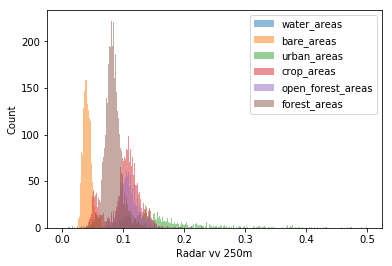

In [17]:
minval = 0.001
maxval = 0.5
bin_values = np.arange(start = minval, stop = maxval, step = 0.001)

legend_list = []
for ttype in training_types:
    plt.hist(zs2[ttype], bins = bin_values, alpha = 0.5)
    legend_list.append(ttype)
    
plt.legend(legend_list)
plt.xlabel('Radar vv 250m')
plt.ylabel('Count')

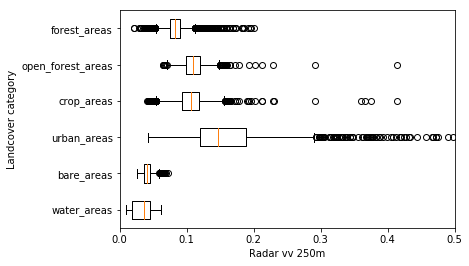

In [18]:
data_list = []
legend_list = []
for ttype in training_types:
    data_list.append(zs2[ttype])
    legend_list.append(ttype)

plt.boxplot(data_list, vert = False)
plt.yticks([1, 2, 3, 4, 5, 6], legend_list)
plt.xlim(0, 0.5)
plt.ylabel('Landcover category')
plt.xlabel('Radar vv 250m')